# Least Squares

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2


<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [ ]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Least Squares Fit

As an example, let's return to the scenario from Chapter xxx.
Suppose you are a researcher in Antarctica, studying local populations of penguins.
Are part of your data collection, you capture a sample of penguins, measure and weigh them -- and then release them unharmed.
But it is notoriously difficult to get penguins to stay on the scale long enough to get an accurate measurement.
So let's suppose that for some penguins we have measurements like flipper length, but no weights.
Maybe we can use the other measurements to fill in the missing data -- this process is called **imputation**.

We'll start by exploring the relationship between the weights and measurements, using data collected between 2007 and 2010 by researchers at Palmer Station in Antarctica.
The data they collected is freely available -- instructions for downloading it are in the notebook for this chapter.

The following cell downloads the data from a repository created by Allison Horst.

In [83]:
download(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins_raw.csv"
)

<IPython.core.display.Javascript object>

In [5]:
penguins = pd.read_csv("penguins_raw.csv").dropna(subset=["Body Mass (g)"])
penguins.shape

(342, 17)

<IPython.core.display.Javascript object>

The dataset includes measurements of 151 Adélie penguins.
We can use `query` to select the rows that contain this data.

In [6]:
adelie = penguins.query('Species.str.startswith("Adelie")')
len(adelie)

151

<IPython.core.display.Javascript object>

Now suppose we know the flipper length of an Adélie penguin -- let's see how well we can predict its weight.
First we'll select these columns from the `DataFrame`.

In [7]:
xvar = "Flipper Length (mm)"
yvar = "Body Mass (g)"

flipper_length = adelie[xvar]
body_mass = adelie[yvar]

<IPython.core.display.Javascript object>

Here's a scatter plot showing the relationship between these quantities.

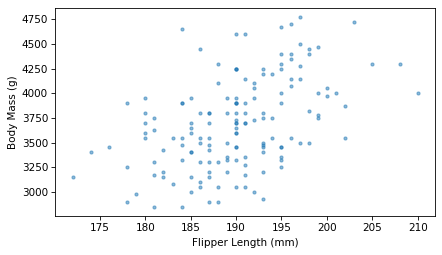

<IPython.core.display.Javascript object>

In [8]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)
decorate(xlabel=xvar, ylabel=yvar)

It looks like they are related -- we can quantify the strength of the relationship by computing the coefficient of correlation.

In [9]:
np.corrcoef(flipper_length, body_mass)[0, 1]

0.4682016942179394

<IPython.core.display.Javascript object>

The correlation is about 0.47, so penguins with longer flippers tend to be heavier.
That's useful because it means we can guess a penguin's weight more accurately if we know its flipper length, but correlation alone doesn't tell us how to make those guesses.
For that, we need to choose a **line of best fit**.

There are many ways to define the "best" line, but for data like this a common choice is a **linear least squares** fit, which is the straight line that minimizes the mean squared error (MSE).

SciPy provides a function called `linregress` that computes a least squares fit.
The name is short for **linear regression**, which is another term for a least squares fit.
Here's how we use it.

In [10]:
from scipy.stats import linregress

result = linregress(flipper_length, body_mass)
result

LinregressResult(slope=32.83168975115009, intercept=-2535.8368022002514, rvalue=0.46820169421793933, pvalue=1.3432645947790051e-09, stderr=5.076138407990821, intercept_stderr=964.7984274994059)

<IPython.core.display.Javascript object>

The result is a `LinregressResult` object that contains the slope and intercept of the fitted line, along with other information we'll unpack soon.
The slope is about 32.8, which means that each additional millimeter of flipper length is associated with an addition 32.8 grams of body weight.

The intercept is -2535 grams, which might seem nonsensical, since a measured weight can't be negative.
It might make more sense if we use the slope and intercept to evaluate the fitted line at the average flipper length.

In [11]:
x = flipper_length.mean()
y = result.intercept + result.slope * x
x, y

(189.95364238410596, 3700.662251655629)

<IPython.core.display.Javascript object>

For a penguin with flipper length 190 mm, the expected body weight is about 3700 grams.

The following function takes the result object and a sequence of `xs` and finds the point on the fitted line for each value of `x`.

In [12]:
def predict(result, xs):
    ys = result.intercept + result.slope * xs
    return ys

<IPython.core.display.Javascript object>

The name `predict` might seem odd here -- in natural language, a prediction usually pertains to something happening in the future, but in the context of regression, the points on the fitted line are called predictions.

We can use `predict` to compute the points on the line for a range of flipper sizes.

In [13]:
fit_xs = np.linspace(np.min(flipper_length), np.max(flipper_length))
fit_ys = predict(result, fit_xs)

<IPython.core.display.Javascript object>

Here's the fitted line alone with the scatter plot of the data.

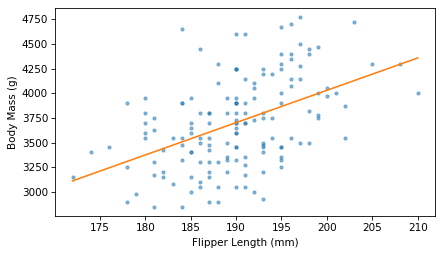

<IPython.core.display.Javascript object>

In [14]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel=xvar, ylabel=yvar)

As expected, the fitted line goes through the center of the data and follows the trend.
And some of the predictions are accurate -- but many of the data points are far from the line.
To get a sense of how good (or bad) the predictions are, we can compute the prediction error, which is the vertical distance of each point from the line.
The following function computes these errors, which are also called **residuals**.

In [15]:
def compute_residuals(result, xs, ys):
    fit_ys = predict(result, xs)
    return ys - fit_ys

<IPython.core.display.Javascript object>

Here are the residuals for body mass as a function of flipper length.

In [16]:
residuals = compute_residuals(result, flipper_length, body_mass)

<IPython.core.display.Javascript object>

As an example, we can look at the results for the first penguin in the dataset.

In [17]:
x = flipper_length[0]
y = predict(result, x)
x, y

(181.0, 3406.699042757914)

<IPython.core.display.Javascript object>

The flipper length of the selected penguin is 181 mm and the predicted body mass is 3407 grams.

In [18]:
body_mass[0], residuals[0]

(3750.0, 343.30095724208604)

<IPython.core.display.Javascript object>

The actual mass of this penguin is 3750 grams, so the residual -- after subtracting away the prediction -- is 343 grams.

The average of the squared residuals is the mean squared error (MSE) of the predictions.

In [19]:
mse = np.mean(residuals**2)
mse

163098.85902884745

<IPython.core.display.Javascript object>

By itself, this number doesn't mean very much.
We can make more sense of it by computing the coefficient of determination.

## Coefficient of Determination

Suppose you want to guess the weight of a penguin.
If you know it's flipper length, you can use the least squares fit to inform your guess, and the MSE quantifies the accuracy of your guesses, on average.

But what if you don't know the flipper length -- what would you guess?
It turns out that the best strategy is to guess the mean.
In that case, the prediction errors are the deviations from the mean.



In [20]:
deviations = body_mass - np.mean(body_mass)

<IPython.core.display.Javascript object>

And the MSE is the mean squared deviation.

In [21]:
np.mean(deviations**2)

208890.28989956583

<IPython.core.display.Javascript object>

And you might remember that the mean squared deviation is the variance.

In [22]:
np.var(body_mass)

208890.28989956583

<IPython.core.display.Javascript object>

So we can think of the variance of the masses as the MSE if we always guess the mean, and the variance of the residuals as the MSE if we use the regression line.
If we compute the ratio of these variances and subtract it from 1, the result indicates how much the MSE is reduce if we use flipper lengths to inform our guesses.

The following function computes this value, which is technically called the **coefficient of determination**, but because it is denoted $R^2$, most people call it "R squared".

In [23]:
def coefficient_of_determination(ys, residuals):
    return 1 - np.var(residuals) / np.var(ys)

<IPython.core.display.Javascript object>

In the example, $R^2$ is about 0.22, which means that the fitted line reduces MSE by 22%.

In [24]:
R2 = coefficient_of_determination(body_mass, residuals)
R2

0.21921282646854912

<IPython.core.display.Javascript object>

It turns out that there's a relationship between the coefficient of determination, $R^2$, and the coefficient of correlation, $r$.
As you might guess, just based on the notation, $r^2 = R^2$.

We can show that's true by computing the square root of $R^2$.

In [25]:
r = np.sqrt(R2)
r

0.4682016942179397

<IPython.core.display.Javascript object>

And comparing it to the correlation we computed earlier.

In [26]:
corr = np.corrcoef(flipper_length, body_mass)[0, 1]
corr

0.4682016942179394

<IPython.core.display.Javascript object>

The `linregress` function also computes this value and returns it as an attribute in the `RegressionResult` object.

In [27]:
result.rvalue

0.46820169421793933

<IPython.core.display.Javascript object>

The coefficients of determination and correlation convey mostly the same information, but they are interpreted differently:

* Correlation quantifies the strength of the relationship on a scale from -1 to 1.

* $R^2$ quantifies the ability of the fitted line to reduce MSE.

Also, $R^2$ is always positive, so it doesn't indicate whether the correlation is positive or negative.



## Minimizing MSE

Earlier I said that the least squares fit is the straight line that minimizes the mean squared error (MSE).
We won't prove that, but we can test it by adding small random values to the intercept and slope, and checking whether the MSE gets worse.

The `types` module provides a `SimpleNamespace` object we can use to make a an object with `intercept` and `slope` attributes.

In [28]:
from types import SimpleNamespace

intercept = result.intercept + np.random.normal(0, 1)
slope = result.slope + np.random.normal(0, 1)
fake_result = SimpleNamespace(intercept=intercept, slope=slope)
fake_result

namespace(intercept=-2534.788485612038, slope=31.51552767819861)

<IPython.core.display.Javascript object>

We can pass this object to `compute_residuals` and use the residuals to compute the MSE.

In [29]:
fake_residuals = compute_residuals(fake_result, flipper_length, body_mass)
fake_mse = np.mean(fake_residuals**2)

<IPython.core.display.Javascript object>

If we compare the result to the MSE of the least squares line, it is always worse.

In [30]:
mse, fake_mse, fake_mse > mse

(163098.85902884745, 225154.2587637279, True)

<IPython.core.display.Javascript object>

Minimizing MSE is nice, but it's not the only definition of "best".
One alternative is to minimize the absolute values of the errors (MAE).
Another is to minimize the shortest distance from each point to the fitted line, which is called the "total error".
In some contexts, guessing too high might be better (or worse) than guessing too low.
In that case you might want to compute a cost function for each residual, and minimize total cost.

But the least squares fit is much more widely used than the alternatives, primarily because it is efficient to compute.
The following function shows how.

In [31]:
def least_squares(xs, ys):
    xbar = np.mean(xs)
    ybar = np.mean(ys)

    xdev = xs - xbar
    ydev = ys - ybar

    slope = np.sum(xdev * ydev) / np.sum(xdev**2)
    intercept = ybar - slope * xbar

    return intercept, slope

<IPython.core.display.Javascript object>

To test this function, we'll use flipper length and body mass again.

In [32]:
intercept, slope = least_squares(flipper_length, body_mass)
intercept, slope

(-2535.8368022002524, 32.831689751150094)

<IPython.core.display.Javascript object>

And we can confirm that we get the same results we got from `linregress`.

In [33]:
np.allclose([intercept, slope], [result.intercept, result.slope])

True

<IPython.core.display.Javascript object>

Minimizing MSE made sense when computational efficiency was more important than choosing the method most appropriate to the problem at hand.
But that's no longer the case, so it is worth considering whether squared residuals are the right thing to minimize.

## Estimation

The parameters `slope` and `intercept` are estimates based on a sample; like other estimates, they are vulnerable to non-representative sampling, measurement error, and variability due to random sampling.
As usual, it's hard to quantify the effect of non-representative sampling and measurement error.
It's easier to quantify the effect of random sampling -- by running simulated experiments and computing sampling distributions of the estimates.

We can simulate the experiments by resampling the data; that is, by treating the sample as if it were the whole population and drawing new samples, with replacement, from the observed data.
The following function takes a `DataFrame` and uses the `sample` method to resample the rows and return a new `DataFrame`.

In [34]:
def resample(df):
    n = len(df)
    return df.sample(n, replace=True)

<IPython.core.display.Javascript object>

And the following function takes a `DataFrame`, finds the least squares fit, and returns the slope of the fitted line.

In [35]:
def estimate_slope(df):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    return result.slope

<IPython.core.display.Javascript object>

We can use these functions to generate many simulated datasets and compute the slope for each one.

In [36]:
resampled_slopes = [estimate_slope(resample(adelie)) for i in range(1001)]

<IPython.core.display.Javascript object>

The result is a sample from the sampling distribution of the slope.
Here's what it looks like.

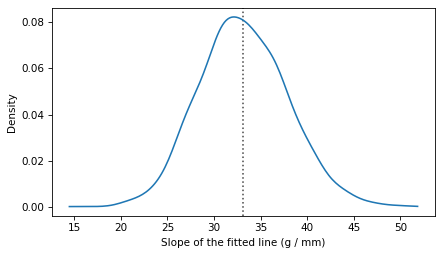

<IPython.core.display.Javascript object>

In [37]:
from thinkstats import plot_kde

plot_kde(resampled_slopes)

decorate(xlabel="Slope of the fitted line (g / mm)", ylabel="Density")

We can use `percentile` to compute a 90% confidence interval.

In [38]:
ci90 = np.percentile(resampled_slopes, [5, 95])
print(result.slope, ci90)

32.83168975115009 [25.8502323  40.87664045]


<IPython.core.display.Javascript object>

So we could report that the estimated slope is 33 grams / mm with a 90% CI [26, 41] grams / mm.


In [39]:
stderr = np.std(resampled_slopes)
stderr

4.6699434763284025

<IPython.core.display.Javascript object>

The `RegressionResult` object we got from `linregress` provides an approximation of the standard error, based on some assumptions about the shape of the distribution.

In [40]:
result.stderr

5.076138407990821

<IPython.core.display.Javascript object>

The standard error we computed by resampling is a little smaller, but the difference probably doesn't matter in practice.

Finally, to compute a p-value, we can approximate the sampling distribution with a normal distribution that has the same mean and standard deviation.

In [41]:
from scipy.stats import norm

m, s = np.mean(resampled_slopes), np.std(resampled_slopes)
sampling_dist = norm(m, s)

<IPython.core.display.Javascript object>

Since the estimated slope is positive, the p-value is the probability that the resampled slope is negative, which we can compute with the CDF of the normal distribution.

In [42]:
p_value = sampling_dist.cdf(0)
p_value

6.189075860460712e-13

<IPython.core.display.Javascript object>

The p-value is very small, so we can conclude that the observed slope would have been very unlikely if there were actually no relationship between flipper length and body weight.

## Visualizing Uncertainty

Each time we resample the dataset, we get a different fitted line.
To see how much variation there is in the lines, one option is to loop through them and plot them all.
The following function takes a resampled `DataFrame`, computes a least squares fit, and generates predicted values for a sequence of `xs`.

In [43]:
def fit_line(df, fit_xs):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    fit_ys = predict(result, fit_xs)
    return fit_ys

<IPython.core.display.Javascript object>

Here's the sequence of `xs` we'll use.

In [44]:
xs = adelie["Flipper Length (mm)"]
fit_xs = np.linspace(np.min(xs), np.max(xs))

<IPython.core.display.Javascript object>

And here's what the fitted lines look like, along with a scatter plot of the data.

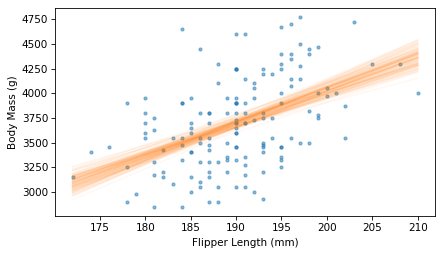

<IPython.core.display.Javascript object>

In [45]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)

for i in range(101):
    fit_ys = fit_line(resample(adelie), fit_xs)
    plt.plot(fit_xs, fit_ys, color="C1", alpha=0.05)

decorate(xlabel=xvar, ylabel=yvar)

Near the middle, the fitted lines are close together -- at the extremes, they are farther apart.

Another way to represent the variability of the fitted lines is to plot a 90% confidence interval for each predicted value.
We can do that by collecting the fitted lines as a list of arrays.

In [46]:
fitted_ys = [fit_line(resample(adelie), fit_xs) for i in range(1001)]

<IPython.core.display.Javascript object>

We can think of this list of arrays as a two-dimensional array with one row for each fitted line and one column corresponding to each of the `xs`.

Now we can use `percentile` with the `axis=0` argument to find the 5th, 50th, and 95th percentiles of the `ys` corresponding to each of the `xs`.

In [47]:
low, median, high = np.percentile(fitted_ys, [5, 50, 95], axis=0)

<IPython.core.display.Javascript object>

Now we'll use `fill_between` to plot a region between the 5th and 95 percentiles, which represents the 90% CI, along with the median value in each column and a scatter plot of the data.

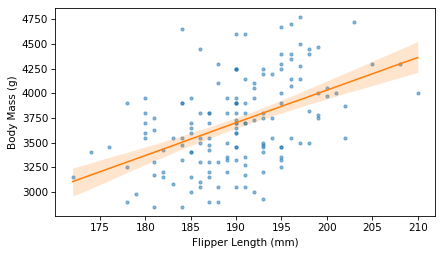

<IPython.core.display.Javascript object>

In [48]:
plt.scatter(flipper_length, body_mass, marker=".", alpha=0.5)

plt.fill_between(fit_xs, low, high, color="C1", lw=0, alpha=0.2)
plt.plot(fit_xs, median, color="C1")

decorate(xlabel=xvar, ylabel=yvar)

This is my favorite way of to represent the variability of a fitted line due to random sampling.

## Transformation

Before fitting a line to data, it is sometimes useful to transform one or both variables, for example by computing the squares of the values, their square roots, or their logarithms.
To demonstrate, we'll use heights and weights from the BRFSS, which we saw in Section xxx.


The following cell downloads the BRFSS data.

In [49]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

<IPython.core.display.Javascript object>

We can load the BRFSS data like this.

In [50]:
from thinkstats import read_brfss

brfss = read_brfss()

<IPython.core.display.Javascript object>

Next we'll select the rows with valid data and select the columns containing heights in centimeters and weights in kilograms. 

In [51]:
valid = brfss.dropna(subset=["htm3", "wtkg2"])
heights, weights = valid["htm3"], valid["wtkg2"]

<IPython.core.display.Javascript object>

We can use `linregress` to compute the slope and intercept of the least squares fit.

In [52]:
result_brfss = linregress(heights, weights)
result_brfss.intercept, result_brfss.slope

(-82.65926054409877, 0.957074585033226)

<IPython.core.display.Javascript object>

The slope is about 0.96, which means that an increase of 1 centimeter corresponds to an increase of almost 1 kilogram, on average.
We can use `predict` again to generate predicted values for a range of `xs`.

In [53]:
fit_xs = np.linspace(heights.min(), heights.max())
fit_ys = predict(result_brfss, fit_xs)

<IPython.core.display.Javascript object>

Before we make a scatter plot of the data, it's useful to jitter the heights and weights.

In [54]:
from thinkstats import jitter

jittered_heights = jitter(heights, 2)
jittered_weights = jitter(weights, 1.5)

<IPython.core.display.Javascript object>

And we'll use the mean and standard deviation of the heights to choose the limits of the $x$ axis.

In [55]:
m, s = heights.mean(), heights.std()
xlim = m - 4 * s, m + 4 * s
ylim = 0, 200

<IPython.core.display.Javascript object>

Here's a scatter plot of the jittered data along with the fitted line.

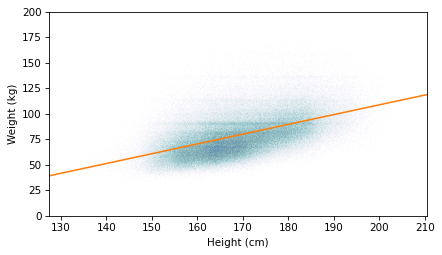

<IPython.core.display.Javascript object>

In [56]:
plt.scatter(jittered_heights, jittered_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel="Height (cm)", ylabel="Weight (kg)", xlim=xlim, ylim=ylim)

It might seem like the fitted line doesn't pass through the densest part of the scatter plot.
That's because the weights don't follow a normal distribution.
As we saw in Section xxx (Chapter 5), adult weights tend to follow a lognormal distribution, which is skewed toward larger values -- and that pulls the fitted line up.

Another cause for concern is the distribution of the residuals, which looks like this.

In [57]:
residuals = compute_residuals(result_brfss, heights, weights)

<IPython.core.display.Javascript object>

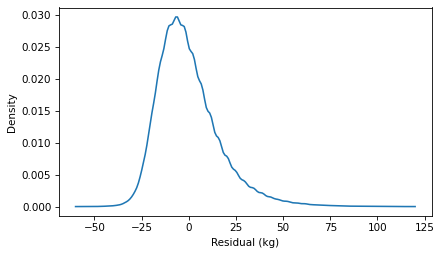

<IPython.core.display.Javascript object>

In [58]:
from thinkstats import make_pmf

pmf_kde = make_pmf(residuals, -60, 120)
pmf_kde.plot()

decorate(xlabel="Residual (kg)", ylabel="Density")

The distribution of the residuals is skewed to the right.
By itself, that's not necessarily a problem, but it suggests that the least squares fit has not described the relationship between these variables precisely.

If the weights follow a lognormal distribution, their logarithms follow a normal distribution.
So let's see what happens if we fit a line to the logarithms of weight as a function of height.

In [59]:
log_weights = np.log10(weights)
result_brfss2 = linregress(heights, log_weights)
result_brfss2.intercept, result_brfss2.slope

(0.9930804163932876, 0.005281454169417777)

<IPython.core.display.Javascript object>

Because we transformed one of the variables, the slope and intercept are harder to interpret.
But we can use `predict` to compute the fitted line.

In [60]:
fit_xs = np.linspace(heights.min(), heights.max())
fit_ys = predict(result_brfss2, fit_xs)

<IPython.core.display.Javascript object>

And then plot it along with a scatter plot of the transformed data.

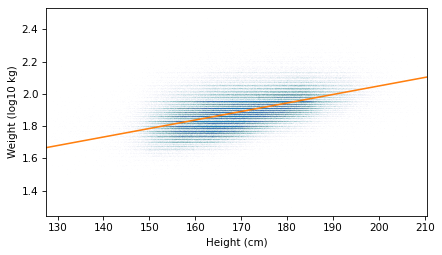

<IPython.core.display.Javascript object>

In [61]:
jittered_log_weights = jitter(log_weights, 1.5)
plt.scatter(jittered_heights, log_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel="Height (cm)", ylabel="Weight (log10 kg)", xlim=xlim)

The fitted line passes through the densest part of the plot, and the actual values extend about the same distance above and below the line.
And the distribution of the residuals is roughly symmetric.

In [62]:
residuals = compute_residuals(result, heights, log_weights)

<IPython.core.display.Javascript object>

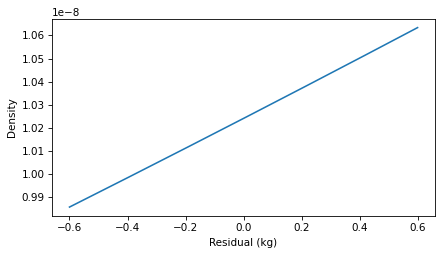

<IPython.core.display.Javascript object>

In [63]:
pmf_kde = make_pmf(residuals, -0.6, 0.6)
pmf_kde.plot()

decorate(xlabel="Residual (kg)", ylabel="Density")

The appearance of the scatter plot and the distribution of the residuals suggest that the relationship of height and log-transformed weight is well described by the fitted line.
If we compare the $r$ values of the two regressions, we see that the correlation of height with log-transformed weights is slightly higher. 

In [64]:
result_brfss.rvalue, result_brfss2.rvalue

(0.5087364789734582, 0.5317282605983435)

<IPython.core.display.Javascript object>

Which means that the $R^2$ value is slightly higher, too.

In [65]:
result_brfss.rvalue**2, result_brfss2.rvalue**2

(0.2588128050383119, 0.28273494311893993)

<IPython.core.display.Javascript object>

If we use heights to guess weights, the guesses will be a little better if we work with the log-transformed weights.

However, transforming the data can make the results harder to interpret -- it can help to invert the transformation before presenting the results.
For example, the inverse of a logarithm in base 10 is exponentiation with base 10.
Here's what the fitted line looks like after the inverse transformation, along with the untransformed data.

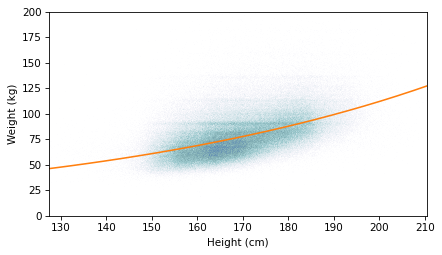

<IPython.core.display.Javascript object>

In [66]:
plt.scatter(jittered_heights, jittered_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, 10**fit_ys, color="C1")
decorate(xlabel="Height (cm)", ylabel="Weight (kg)", xlim=xlim, ylim=ylim)

A fitted line that's straight with respect to the transformed data is curved with respect to the original data.

## Glossary

-   **linear fit**: a line intended to model the relationship between variables.

-   **least squares fit**: A model of a dataset that minimizes the sum of squares of the residuals.

-   **residual**: The deviation of an actual value from a model.

-   **goodness of fit**: A measure of how well a model fits data.

-   **coefficient of determination**: A statistic intended to quantify goodness of fit.

-   **sampling weight**: A value associated with an observation in a sample that indicates what part of the population it represents.

# Exercises

## Exercise

In this chapter we computed a least squares fit for penguin weights as a function of flipper length.
There are two other measurements in the dataset we can also consider: culmen length and culmen depth (the culmen is the top ridge of the bill).

Compute the least squares fit for weight as a function of culmen length.
Make a scatter plot of these variables and plot the fitted line.

Based on the `rvalue` attribute of the `RegressionResult` object, what is the correlation of these variables?
What is the coefficient of determination?
Which is a better predictor of weight, culmen length or flipper length?

In [67]:
xvar = "Culmen Length (mm)"
yvar = "Body Mass (g)"

culmen_length = adelie[xvar]
body_mass = adelie[yvar]

<IPython.core.display.Javascript object>

In [68]:
# Solution

result = linregress(culmen_length, body_mass)
result

LinregressResult(slope=94.4998154013297, intercept=34.88298865371735, rvalue=0.5488658064533206, pvalue=2.9547579193016823e-13, stderr=11.790478185101202, intercept_stderr=458.43870972286123)

<IPython.core.display.Javascript object>

In [69]:
# Solution

fit_xs = np.linspace(np.min(culmen_length), np.max(culmen_length))
fit_ys = predict(result, fit_xs)

<IPython.core.display.Javascript object>

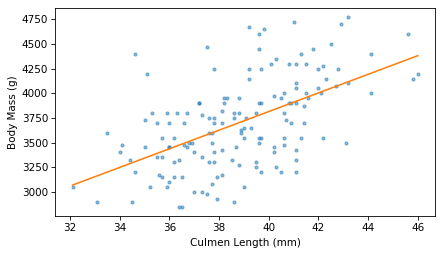

<IPython.core.display.Javascript object>

In [70]:
# Solution

plt.scatter(culmen_length, body_mass, marker=".", alpha=0.5)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel=xvar, ylabel=yvar)

In [71]:
# Solution

# The correlation, r, and coefficient of determination, R^2,
# are higher for culmen length than for flipper length, so
# culmen length makes slightly better predictions.

r = result.rvalue
R2 = result.rvalue**2

r, R2

(0.5488658064533206, 0.301253673493654)

<IPython.core.display.Javascript object>

## Exercise

In this chapter we used resampling to compute the sampling distribution for the slope of a fitted line.
We can compute the sampling distribution of the intercept the same way:

1. Write a function called `estimate_intercept` that takes a resampled `DataFrame` as an argument, computes the least squares fit of penguin weight as a function of flipper length, and returns the intercept.

2. Call the function with many resampled versions of `adelie` and collect the intercepts.

3. Use `plot_kde` to plot the sampling distribution of the intercept.

4. Compute the standard error and a 90% confidence interval.

5. Check that the standard error you get from resampling is consistent with the `intercept_stderr` attribute in the `RegressionResult` object -- it might be a little smaller.

In [72]:
# Solution


def estimate_intercept(df):
    xs, ys = df["Flipper Length (mm)"], df["Body Mass (g)"]
    result = linregress(xs, ys)
    return result.intercept

<IPython.core.display.Javascript object>

In [73]:
# Solution

resampled_intercepts = [estimate_intercept(resample(adelie)) for i in range(1001)]

<IPython.core.display.Javascript object>

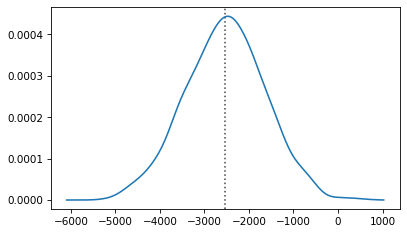

<IPython.core.display.Javascript object>

In [74]:
# Solution

plot_kde(resampled_intercepts)

In [75]:
# Solution

ci90 = np.percentile(resampled_intercepts, [5, 95])
ci90

array([-4040.06826471, -1080.07020139])

<IPython.core.display.Javascript object>

In [76]:
# Solution

intercept_stderr = np.std(resampled_intercepts)
intercept_stderr, result.intercept_stderr

(890.4722407653505, 458.43870972286123)

<IPython.core.display.Javascript object>

## Exercise

A person's Body Mass Index (BMI) is their weight in kilograms divided by their height in meters raised to the second power.
In the BRFSS dataset, we can compute BMI like this, after converting heights from centimeters to meters.

In [77]:
heights_m = heights / 100
bmis = weights / heights_m**2

<IPython.core.display.Javascript object>

In this definition, heights are squared, rather than raised to some other exponent, because of the observation -- early in the history of statistics -- that average weight increases roughly in proportion to height squared.

To see whether that's true, we can use data from the BRFSS, a least squares fit, and a little bit of math.
Suppose weight is proportional to height raised to an unknown exponent, $a$.
In that case, we can write:

$$w = b h^a$$

where $w$ is weight, $h$ is height, and $b$ is an unknown constant of proportionality.
Taking logarithms of both sides:

$$\log w = \log b + a \log h$$

So, if we compute a least squares fit for log-transformed weights as a function of log-transformed heights, the slope of the fitted line estimates the unknown exponent $a$.

Compute the logarithms of height and weight.
You can use any base for the logarithms, as long as it's the same for both transformations.
Compute a least squares fit.
Is the slope close to 2?

In [78]:
# Solution

log_heights = np.log10(heights)

<IPython.core.display.Javascript object>

In [79]:
# Solution

result = linregress(log_heights, log_weights)
result.intercept, result.slope

(-2.659549956221576, 2.0408900497050517)

<IPython.core.display.Javascript object>

In [80]:
# Solution

result.rvalue

0.5288265898723755

<IPython.core.display.Javascript object>

In [81]:
# Solution

fit_xs = np.linspace(log_heights.min(), log_heights.max())
fit_ys = predict(result, fit_xs)

<IPython.core.display.Javascript object>

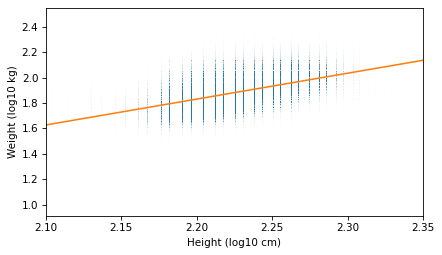

<IPython.core.display.Javascript object>

In [82]:
# Solution

plt.scatter(log_heights, log_weights, alpha=0.01, s=0.1)
plt.plot(fit_xs, fit_ys, color="C1")
decorate(xlabel="Height (log10 cm)", ylabel="Weight (log10 kg)", xlim=[2.1, 2.35])